In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [213]:
data = pd.read_csv('/content/drive/MyDrive/CPI_NCKH/cpi_data.csv')
data['time'] = pd.to_datetime(data['time'])
data = data[(data['time'].dt.year > 1995)]
data

,time,cpi_mom,cpi_yoy
12,1996-01-01,100.90,109.76
13,1996-02-01,102.50,108.80
14,1996-03-01,100.80,109.46
15,1996-04-01,100.10,108.48
16,1996-05-01,99.50,106.03
...,...,...,...
355,2024-08-01,100.00,103.47
356,2024-09-01,100.29,102.66
357,2024-10-01,100.33,102.91
358,2024-11-01,100.13,102.79


### Hàm tính giá trị MAPE

In [214]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.inf

In [215]:
def create_lag_features(df, target_col):
    df_copy = df.copy()
    df_copy['lag1'] = df_copy[target_col].shift(1)
    df_copy['lag12'] = df_copy[target_col].shift(12)
    df_copy = df_copy.dropna()
    return df_copy

In [216]:
def split_data(df, target_col):
    X = df[['lag1', 'lag12']]
    y = df[target_col]
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    return X_train, X_test, y_train, y_test

In [217]:
def plot_gridsearch(means, sterr, params, paramsnames, scoring, plot_subname='test', savefig=False, output_dir=None, plotfig=False):
    if len(params) > 2:
        return
    import matplotlib.pyplot as plt
    fig = plt.figure()
    if len(params) == 2:
        p1, p2 = params[0], params[1]
        p1name, p2name = paramsnames[0], paramsnames[1]
        scores = np.reshape(means, (len(p1), len(p2)))
        yerrs = np.reshape(sterr, (len(p1), len(p2)))
        for i, value in enumerate(p1):
            plt.errorbar(p2, scores[i], yerr=yerrs[i], fmt='o-', label=f'{p1name}: {value}')
        plt.legend(loc='best')
        plt.xlabel(p2name)
        plt.ylabel(scoring)
    else:
        p1 = params[0]
        p1name = paramsnames[0]
        scores = np.array(means)
        yerrs = np.array(sterr)
        plt.errorbar(p1, scores, yerr=yerrs, fmt='o-', label=p1name)
        plt.xlabel(p1name)
        plt.ylabel(scoring)
    plt.grid(True)
    if savefig and output_dir:
        plt.savefig(output_dir + 'gridsearch_' + plot_subname + '.png', dpi=300)
    if plotfig:
        plt.show()

In [218]:
def analyse(grid_result, grid_hyper_parameter, gridsearch_params, plotlabel, verbose, plotting):
    n_folds = gridsearch_params['cv']
    scoring = gridsearch_params['scoring']
    if verbose:
        print('_________________\n\nFinished Grid Search:')
        print('trying: ', grid_hyper_parameter)
        print(f'\nBest: {grid_result.best_score_:.6f} using {grid_result.best_params_}')
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    if verbose:
        for mean, stdev, param in zip(means, stds, params):
            print(f"{mean:.6f} ({stdev:.6f}) with: {param}")
    sterrs = np.divide(stds, n_folds)
    if plotting:
        plot_gridsearch(means, sterrs, grid_hyper_parameter.values(), grid_hyper_parameter.keys(), scoring, plot_subname=f'grid_{plotlabel}_', output_dir='./', savefig=True)



In [219]:
def grid_search_tuning(X, y, hyperparameter_grids, booster, gridsearch_params={'cv': 5, 'scoring': 'neg_mean_squared_error'}, verbose=True, plotting=True):
    best_estimator = booster
    for run, hyperparameter_grid in enumerate(hyperparameter_grids):
        gridparams = {'estimator': best_estimator, 'param_grid': hyperparameter_grid}
        gridparams.update(gridsearch_params)
        grid_result = GridSearchCV(**gridparams).fit(X, np.squeeze(y))
        best_estimator = grid_result.best_estimator_
        if verbose or plotting:
            analyse(grid_result, hyperparameter_grid, gridparams, run, verbose, plotting)
    return best_estimator

In [220]:
def train_evaluate_xgboost(X_train, X_test, y_train, y_test, target_col):
    grids_xgb = [
        {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.3]},
        {'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
        {'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}
    ]
    booster = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    gridsearch_params = {'cv': 5, 'scoring': 'neg_mean_squared_error', 'verbose': 1}

    print(f"\nHuấn luyện XGBoost cho {target_col}...")
    best_model = grid_search_tuning(X_train, y_train, grids_xgb, booster, gridsearch_params=gridsearch_params, verbose=True, plotting=False)
    print(f"Tham số tốt nhất (XGBoost - {target_col}):", best_model.get_params())

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nKết quả đánh giá trên tập kiểm tra (XGBoost - {target_col}):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    print(f"Chỉ số R^2: {r2:.4f}")

    return y_pred

In [221]:
def train_evaluate_random_forest(X_train, X_test, y_train, y_test, target_col):
    grids_rf = [
        {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
        {'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
        {'max_features': ['sqrt', 'log2']}
    ]
    rf = RandomForestRegressor(random_state=42)
    gridsearch_params = {'cv': 5, 'scoring': 'neg_mean_squared_error', 'verbose': 1}

    print(f"\nHuấn luyện Random Forest cho {target_col}...")
    best_model = grid_search_tuning(X_train, y_train, grids_rf, rf, gridsearch_params=gridsearch_params, verbose=True, plotting=False)
    print(f"Tham số tốt nhất (Random Forest - {target_col}):", best_model.get_params())

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nKết quả đánh giá trên tập kiểm tra (Random Forest - {target_col}):")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    print(f"Chỉ số R^2: {r2:.4f}")

    return y_pred

In [222]:

def plot_predictions(y_test, y_pred_xgb, y_pred_rf, target_col, time):
    # Tạo DataFrame với thời gian và các giá trị
    plot_data = pd.DataFrame({
        'time': time,
        'Actual': y_test.values,  # Chuyển y_test thành numpy array nếu cần
        'Predicted_XGBoost': y_pred_xgb,
        'Predicted_RandomForest': y_pred_rf
    })

    # Đảm bảo cột 'time' là định dạng datetime
    plot_data['time'] = pd.to_datetime(plot_data['time'])

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(plot_data['time'], plot_data['Actual'], label='Thực tế')
    plt.plot(plot_data['time'], plot_data['Predicted_XGBoost'], label='Dự đoán XGBoost', linestyle='--')
    plt.plot(plot_data['time'], plot_data['Predicted_RandomForest'], label='Dự đoán Random Forest', linestyle='-.')

    # Định dạng biểu đồ
    plt.xlabel('Thời gian')
    plt.ylabel(f'{target_col}')
    plt.title(f'So sánh giá trị {target_col} thực tế và dự đoán')
    plt.legend()
    plt.grid(True)

    # Điều chỉnh layout để tránh cắt nhãn
    plt.tight_layout()

    plt.show()

In [226]:
def plot_residuals(y_test, y_pred_xgb, y_pred_rf, target_col):
    # Tính sai số
    residuals_xgb = y_test - y_pred_xgb
    residuals_rf = y_test - y_pred_rf

    # Tạo figure với 2 hàng: hàng trên là scatter plot, hàng dưới là histogram
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # 1. Biểu đồ sai số (Scatter Plot) - XGBoost
    axes[0, 0].scatter(y_pred_xgb, residuals_xgb, alpha=0.5)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[0, 0].set_xlabel('Giá trị dự đoán')
    axes[0, 0].set_ylabel('Sai số')
    axes[0, 0].set_title(f'Sai số vs Dự đoán - XGBoost ({target_col})')
    axes[0, 0].grid(True)

    # 2. Biểu đồ sai số (Scatter Plot) - Random Forest
    axes[0, 1].scatter(y_pred_rf, residuals_rf, alpha=0.5)
    axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[0, 1].set_xlabel('Giá trị dự đoán')
    axes[0, 1].set_ylabel('Sai số')
    axes[0, 1].set_title(f'Sai số vs Dự đoán - Random Forest ({target_col})')
    axes[0, 1].grid(True)

    # 3. Biểu đồ phân phối sai số (Histogram + Density) - XGBoost
    sns.histplot(residuals_xgb, kde=True, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Sai số')
    axes[1, 0].set_ylabel('Số lượng')
    axes[1, 0].set_title(f'Phân phối sai số - XGBoost ({target_col})')

    # 4. Biểu đồ phân phối sai số (Histogram + Density) - Random Forest
    sns.histplot(residuals_rf, kde=True, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Sai số')
    axes[1, 1].set_ylabel('Số lượng')
    axes[1, 1].set_title(f'Phân phối sai số - Random Forest ({target_col})')

    # Điều chỉnh layout để tránh chồng lấn
    plt.tight_layout()
    plt.show()

In [227]:
def process_target_variable(data, target_col):
    print(f"\n=== Xử lý cho {target_col} ===")

    # Tạo đặc trưng trễ
    df = create_lag_features(data, target_col)

    # Chia dữ liệu
    X_train, X_test, y_train, y_test = split_data(df, target_col)
    print(f"Kích thước tập huấn luyện: {X_train.shape}")
    print(f"Kích thước tập kiểm tra: {X_test.shape}")

    # Lấy thời gian tương ứng với tập kiểm tra từ cột 'time'
    time_test = df['time'].iloc[int(len(df) * 0.8):]

    # Huấn luyện và đánh giá XGBoost
    y_pred_xgb = train_evaluate_xgboost(X_train, X_test, y_train, y_test, target_col)

    # Huấn luyện và đánh giá Random Forest
    y_pred_rf = train_evaluate_random_forest(X_train, X_test, y_train, y_test, target_col)

    # Vẽ biểu đồ so sánh giá trị thực tế và dự đoán (cả hai mô hình)
    plot_predictions(y_test, y_pred_xgb, y_pred_rf, target_col, time_test)

    # Vẽ biểu đồ sai số và phân phối sai số
    plot_residuals(y_test, y_pred_xgb, y_pred_rf, target_col)


=== Xử lý cho cpi_mom ===
Kích thước tập huấn luyện: (268, 2)
Kích thước tập kiểm tra: (68, 2)

Huấn luyện XGBoost cho cpi_mom...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
_________________

Finished Grid Search:
trying:  {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.3]}

Best: -0.531025 using {'learning_rate': 0.01, 'n_estimators': 100}
-0.570090 (0.303497) with: {'learning_rate': 0.01, 'n_estimators': 50}
-0.531025 (0.281662) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.536223 (0.269823) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.616320 (0.295836) with: {'learning_rate': 0.1, 'n_estimators': 50}
-0.647804 (0.304971) with: {'learning_rate': 0.1, 'n_estimators': 100}
-0.668548 (0.306056) with: {'learning_rate': 0.1, 'n_estimators': 200}
-0.677632 (0.316893) with: {'learning_rate': 0.3, 'n_estimators': 50}
-0.689246 (0.317117) with: {'learning_rate': 0.3, 'n_estimators': 100}
-0.691535 (0.317171) with: {'learning_rate': 0.3, 'n_es

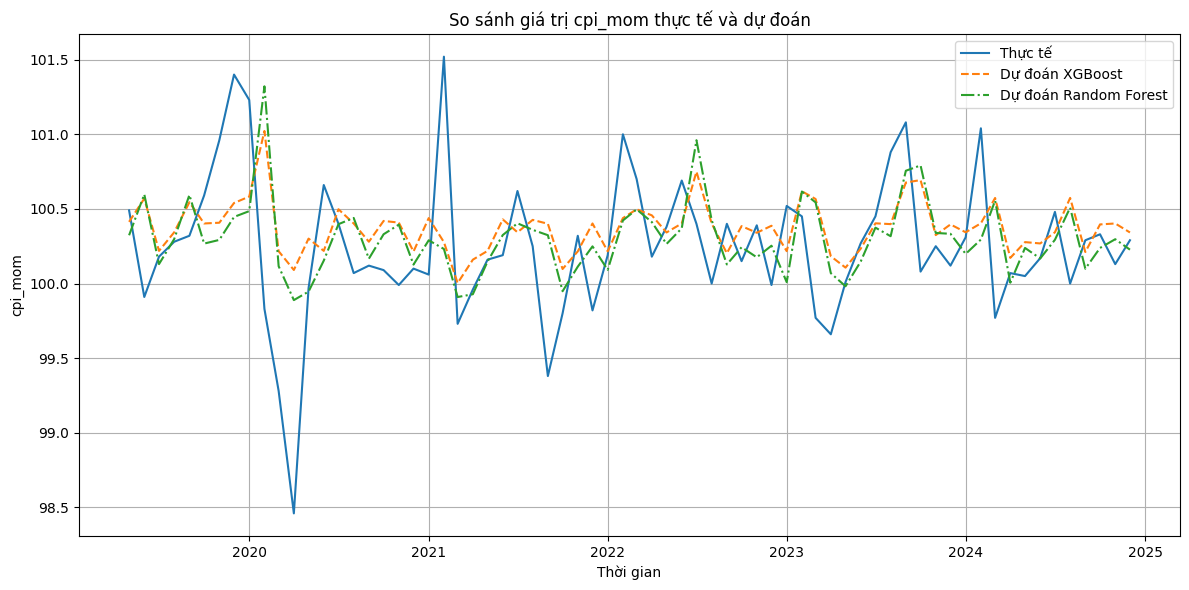

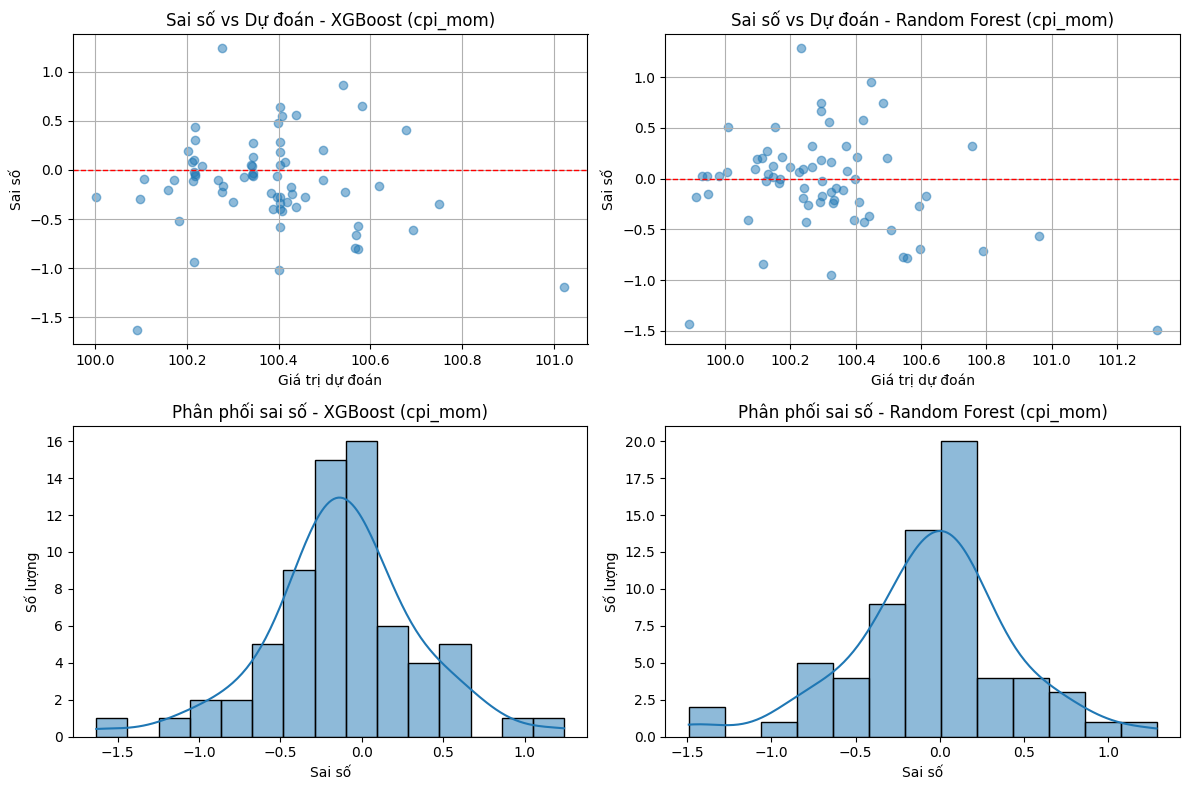


=== Xử lý cho cpi_yoy ===
Kích thước tập huấn luyện: (268, 2)
Kích thước tập kiểm tra: (68, 2)

Huấn luyện XGBoost cho cpi_yoy...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
_________________

Finished Grid Search:
trying:  {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.3]}

Best: -1.865848 using {'learning_rate': 0.3, 'n_estimators': 200}
-19.288566 (14.770299) with: {'learning_rate': 0.01, 'n_estimators': 50}
-9.985300 (8.794468) with: {'learning_rate': 0.01, 'n_estimators': 100}
-3.895778 (4.126010) with: {'learning_rate': 0.01, 'n_estimators': 200}
-1.994717 (1.790378) with: {'learning_rate': 0.1, 'n_estimators': 50}
-1.911746 (1.602007) with: {'learning_rate': 0.1, 'n_estimators': 100}
-1.918835 (1.585432) with: {'learning_rate': 0.1, 'n_estimators': 200}
-1.868601 (1.447197) with: {'learning_rate': 0.3, 'n_estimators': 50}
-1.866501 (1.437753) with: {'learning_rate': 0.3, 'n_estimators': 100}
-1.865848 (1.435914) with: {'learning_rate': 0.3, 'n_e

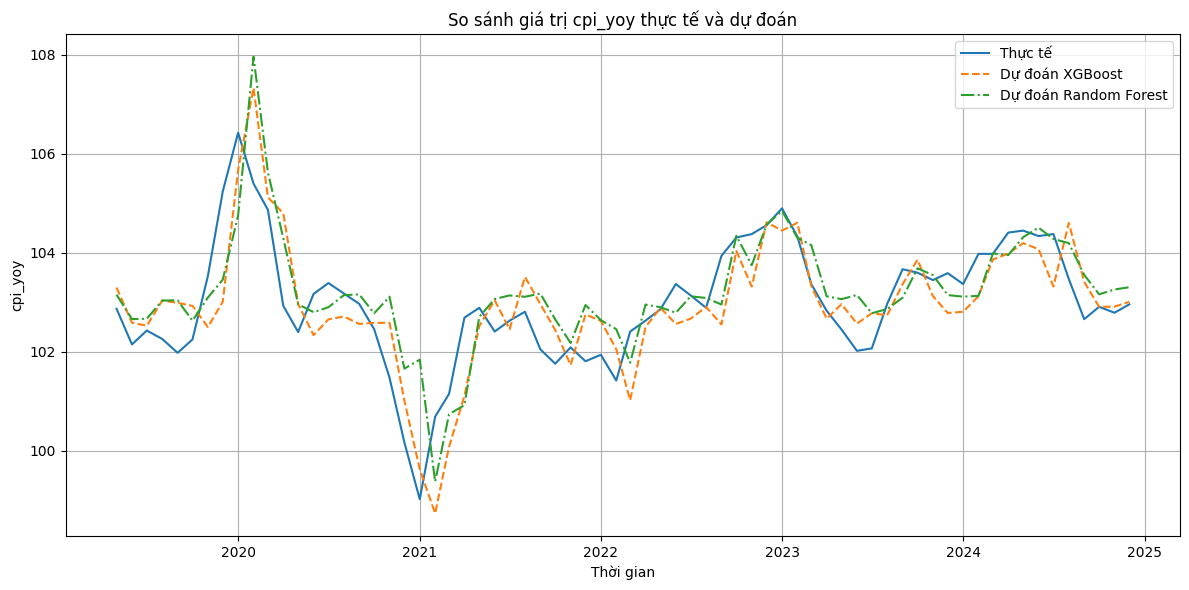

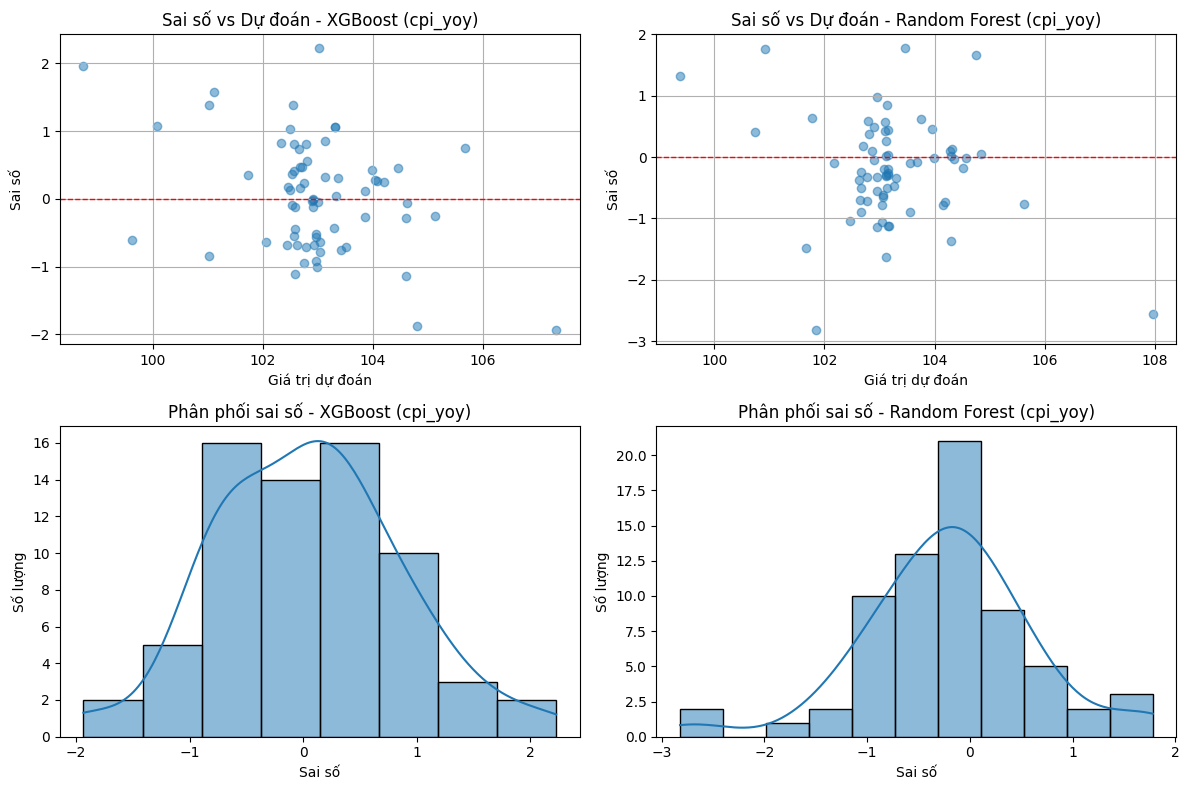

In [228]:
process_target_variable(data, 'cpi_mom')
process_target_variable(data, 'cpi_yoy')